# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [11]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

## Importing necessary libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import timeit
import sklearn.neighbors

**Answer:**

In [13]:
train = np.loadtxt('data/synth_train.txt')
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]

In [14]:
test = np.loadtxt('data/synth_test.txt')
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]

Text(0.5, 1.0, 'Training set')

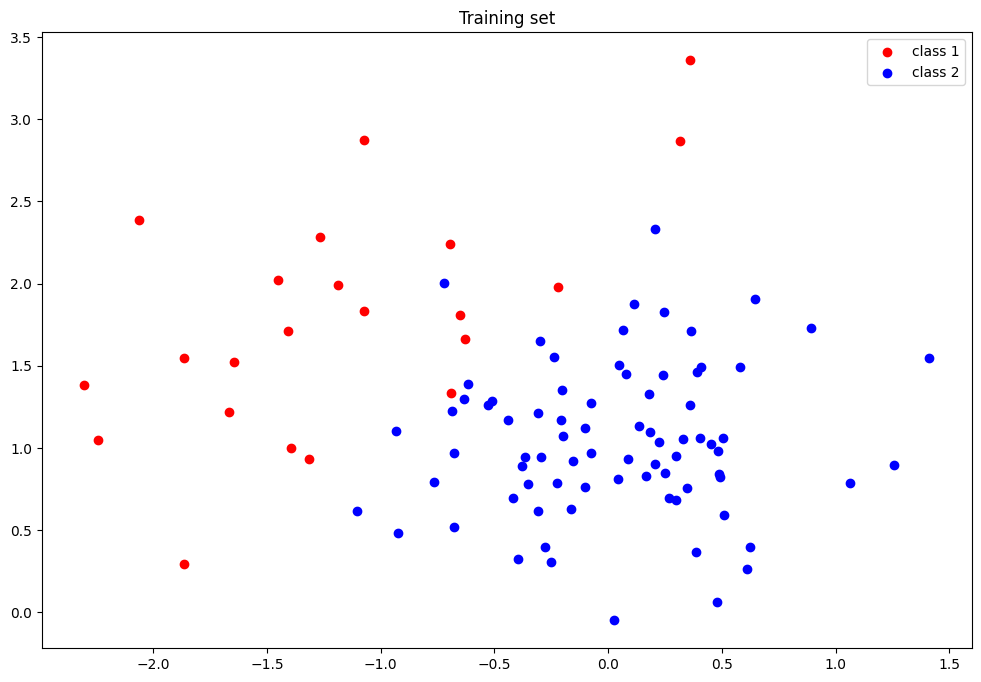

In [15]:
plt.figure(figsize=(12,8),dpi=100)
plt.scatter(x_train[class_train==1,0],x_train[class_train==1,1],c='r',label='class 1')
plt.scatter(x_train[class_train==2,0],x_train[class_train==2,1],c='b',label='class 2')
plt.legend()
plt.title('Training set')

From the plot, we can see that the two classes are linearly separable

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


**Answer:**

In [16]:
def numpy_knn(x_train, class_train, x_test, k):
    ''''
    compute the K-nearest neighbours algorithm for classification.

    Parameters:
    x_train: numpy array
        The training set.
    class_train: numpy array
        The class of each training point.
    x_test: numpy array
        The test set.
    k: int
        The number of neighbours to consider.

    Returns:
    class_test: numpy array
        The class of each test point.
    '''

    N_test = x_test.shape[0]
    N_train = x_train.shape[0]
    class_test = np.zeros(N_test).astype(int)
    dist = np.sqrt(np.sum((x_train[:,np.newaxis] - x_test[np.newaxis])**2, axis=2))
    for i in range(N_test):
        k_nearest = np.argsort(dist[:,i])[:k]
        class_test[i] = np.argmax(np.bincount(class_train[k_nearest].astype(int)))
    return class_test

In [27]:
def naive_knn(x_train, class_train, x_test, k):
    N_test = x_test.shape[0]
    N_train = x_train.shape[0]
    class_test = np.zeros(N_test).astype(int)
    for i in range(N_test):
        distances = np.zeros(N_train, dtype=float)
        for j in range(N_train):
            dist = 0
            for d in range(x_train.shape[1]):
                dist += (x_train[j,d] - x_test[i,d])**2
            distances[j] = np.sqrt(dist)
        k_nearest = np.argsort(distances)[:k]
        class_test[i] = np.argmax(np.bincount(class_train[k_nearest].astype(int)))
    return class_test


In [28]:
def knn_for_reggression(x_train, class_train, x_test, k):

    N_test = x_test.shape[0]
    N_train = x_train.shape[0]
    class_test = np.zeros(N_test).astype(int)
    for i in range(N_test):
        distances = np.zeros(N_train, dtype=float)
        for j in range(N_train):
            dist = 0
            for l in range(x_train.shape[1]):
                dist += (x_train[j,l] - x_test[i,l])**2
            distances[j] = np.sqrt(dist)
        k_nearest = np.argsort(distances)[:k]
        mode_class = int(mode(class_train[k_nearest])[0])
        class_test[i] = mode_class
    return class_test

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

execution time: 0.08183409999992364 seconds


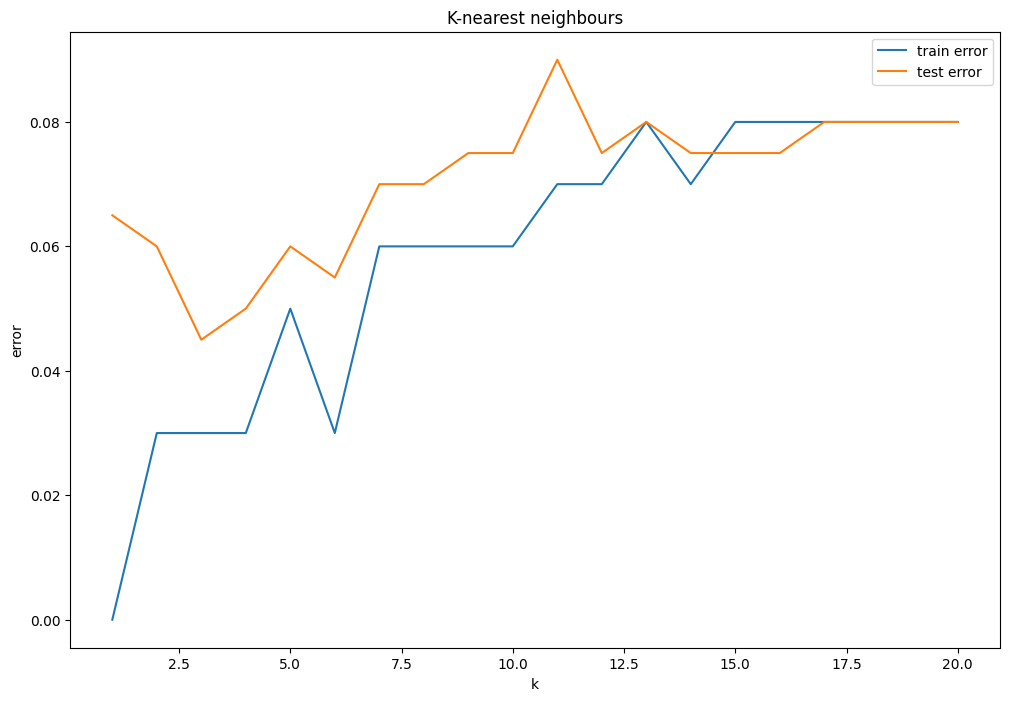

In [18]:
train_error = np.zeros(20)
test_error = np.zeros(20)
start = timeit.default_timer()
for k in range(1,21):
    class_test = numpy_knn(x_train, class_train, x_train, k)
    train_error[k-1] = np.mean(class_test != class_train.astype(int))
    class_test = numpy_knn(x_train, class_train, x_test, k)
    test_error[k-1] = np.mean(class_test != test[:,0].astype(int))
stop = timeit.default_timer()
print(f"execution time: {stop-start} seconds")
plt.figure(figsize=(12,8),dpi=100)
plt.plot(range(1,21),train_error,label='train error')
plt.plot(range(1,21),test_error,label='test error')
plt.legend()
plt.title('K-nearest neighbours')
plt.xlabel('k')
plt.ylabel('error')
plt.show()

execution time: 1.1403301999998803 seconds


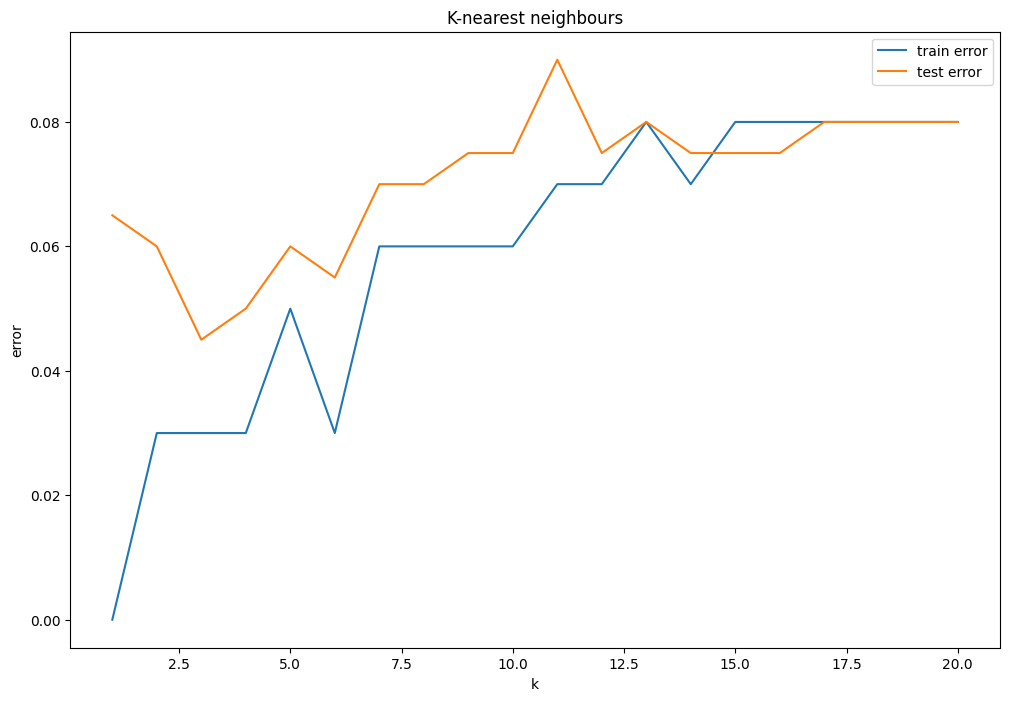

In [29]:
train_error = np.zeros(20)
test_error = np.zeros(20)
start = timeit.default_timer()
for k in range(1,21):
    class_test = naive_knn(x_train, class_train, x_train, k)
    train_error[k-1] = np.mean(class_test != class_train.astype(int))
    class_test = naive_knn(x_train, class_train, x_test, k)
    test_error[k-1] = np.mean(class_test != test[:,0].astype(int))
stop = timeit.default_timer()
print(f"execution time: {stop-start} seconds")
plt.figure(figsize=(12,8),dpi=100)
plt.plot(range(1,21),train_error,label='train error')
plt.plot(range(1,21),test_error,label='test error')
plt.legend()
plt.title('K-nearest neighbours')
plt.xlabel('k')
plt.ylabel('error')
plt.show()

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

We notice that the test set error is lowest when K=3. At the same time, the training set error is zero for K=1, which is expected. This suggests the model is overfitting. Therefore, K=3 offers a better balance between fitting the training data and generalizing to new data.

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

execution time: 0.19559169999956794 seconds


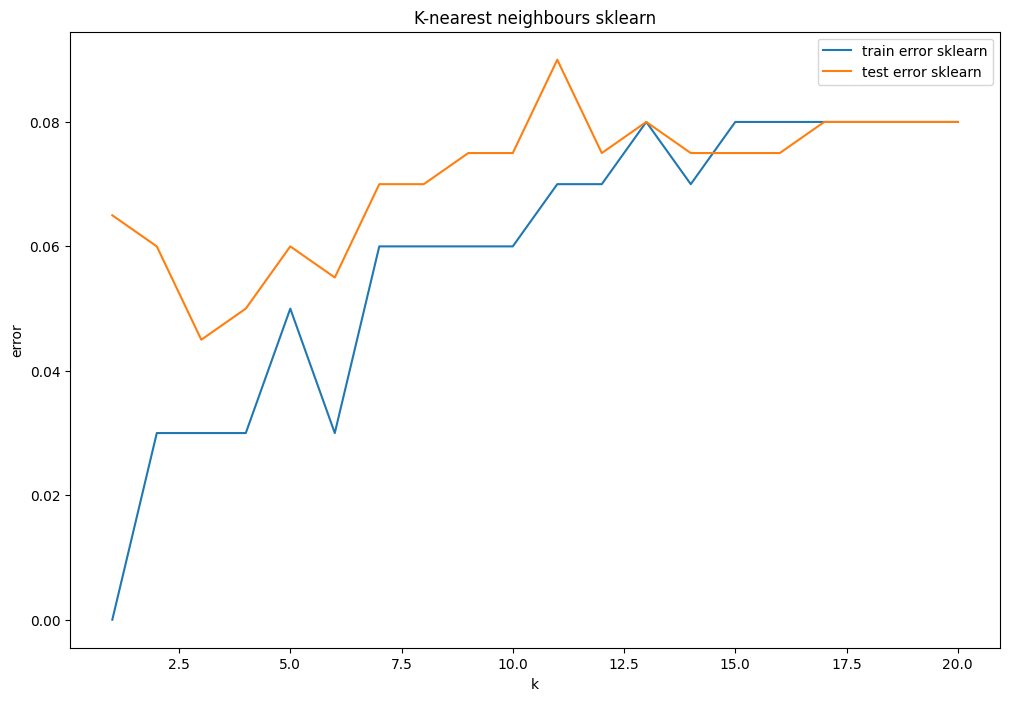

In [30]:
test_error_sklearn = np.zeros(20)
train_error_sklearn = np.zeros(20)
start = timeit.default_timer()
for k in range(1,21):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, class_train)
    train_error_sklearn[k-1] = 1 - knn.score(x_train, class_train)
    test_error_sklearn[k-1] = 1 - knn.score(x_test, test[:,0])
stop = timeit.default_timer()
print(f"execution time: {stop-start} seconds")
plt.figure(figsize=(12,8),dpi=100)
plt.plot(range(1,21),train_error_sklearn,label='train error sklearn')
plt.plot(range(1,21),test_error_sklearn,label='test error sklearn')
plt.legend()
plt.title('K-nearest neighbours sklearn')
plt.xlabel('k')
plt.ylabel('error')
plt.show()

We get the same results as the sklearn implementation of the K-nearest neighbours algorithm. let's compare the execution time of the two implementations.

In [31]:
print("time report for numpy_knn")
timeit_numpy = %timeit -o numpy_knn(x_train, class_train, x_test, 5)
np_time = timeit_numpy.average

print("time report for naive_knn")
timeit_naive = %timeit -o naive_knn(x_train, class_train, x_test, 5)
naive_time = timeit_naive.average

print("time report for sklearn")
timeit_sklearn = %timeit -o sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(x_train, class_train).predict(x_test)
sklearn_time = timeit_sklearn.average


time report for numpy_knn
1.71 ms ± 47.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
time report for naive_knn
34.2 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
time report for sklearn
6.1 ms ± 293 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We observe that we get the same results for three different implementations of the K-nearest neighbours algorithm. In term of speed, the numpy implementation is the fastest, followed by the sklearn implementation and the naive implementation.</br> The numpy implementation is about 20 times faster than the naive implementation and 2.25 times faster than the sklearn implementation. This because the numpy implementation uses vectorized operations which are faster than for loops.</br> The sklearn implementation is slower than the numpy implementation because it is a general implementation that can be used for different types of data and it is not optimized for the specific case of the K-nearest neighbours algorithm.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

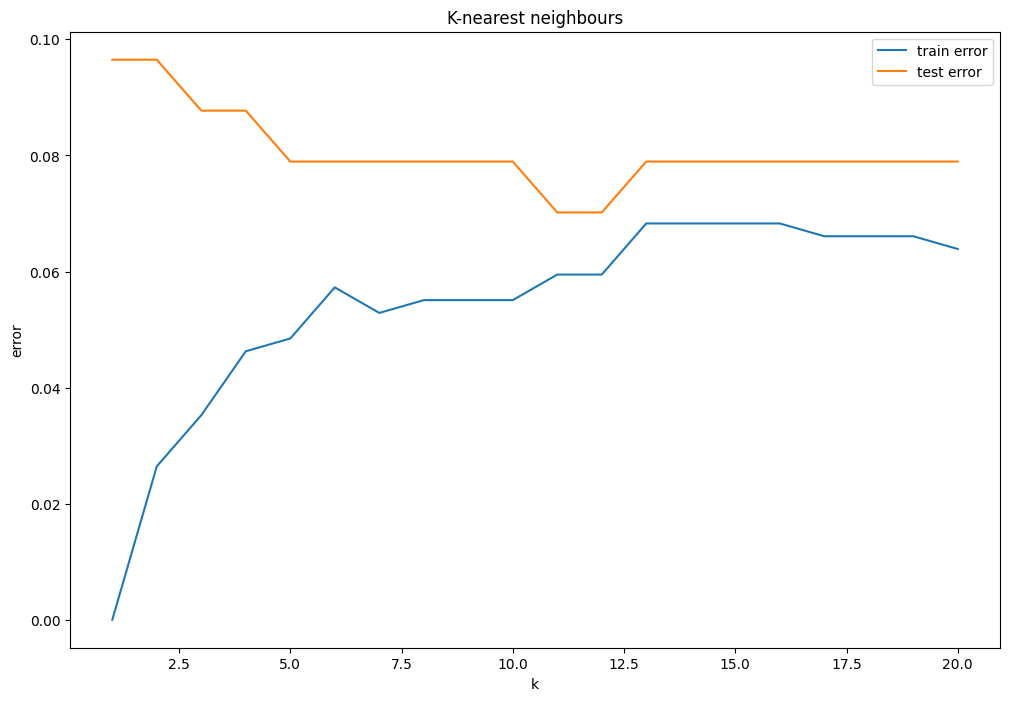

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_breast = pd.read_csv("data/wdbc12.data.txt")
X = data_breast.iloc[:,2:].values
y = data_breast.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_error = np.zeros(20)
test_error = np.zeros(20)

for k in range(1,21):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_error[k-1] = 1 - knn.score(X_train, y_train)
    test_error[k-1] = 1 - knn.score(X_test, y_test)

plt.figure(figsize=(12,8),dpi=100)
plt.plot(range(1,21),train_error,label='train error')
plt.plot(range(1,21),test_error,label='test error')
plt.legend()
plt.title('K-nearest neighbours')
plt.xlabel('k')
plt.ylabel('error')
plt.show()

 We can say that the k that optimizes the test error is around 11 let's plot 

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [13]:
!cd example_cy && python setup.py build_ext --inplace

Compiling helloworld.pyx because it changed.
Compiling primes.pyx because it changed.
[1/2] Cythonizing helloworld.pyx
[2/2] Cythonizing primes.pyx
helloworld.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-312\Release\helloworld.cp312-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-312\Release\helloworld.cp312-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code
primes.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-312\Release\primes.cp312-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-312\Release\primes.cp312-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


In [14]:
import example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [15]:
!cd example_np_cy && python setup.py build_ext --inplace

Compiling compute_cy.pyx because it changed.
[1/1] Cythonizing compute_cy.pyx
compute_cy.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-312\Release\compute_cy.cp312-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-312\Release\compute_cy.cp312-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


In [16]:
import example_np_cy.compute as compute

In [19]:
array_1 = np.random.rand(1000,1000)
array_2 = np.random.rand(1000,1000)
a = 1
b = 2
c = 3

timeit_cy = %timeit -o compute.compute(array_1, array_2, a, b, c)
cy_time = timeit_cy.average

695 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [1]:
!cd KNN && python setup.py build_ext --inplace

Compiling knn.pyx because it changed.
[1/1] Cythonizing knn.pyx
knn.c
c:\Users\33605\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-312\Release\knn.cp312-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-312\Release\knn.cp312-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


c:\Users\33605\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\33605\Desktop\Centrale G3\Python\python_sdia-main\Labs\Lab4\KNN\knn.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [40]:
import KNN.knn as knn

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_breast = pd.read_csv("data/wdbc12.data.txt")
X = data_breast.iloc[:,2:].values
y = data_breast.iloc[:,1].values.astype('int')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

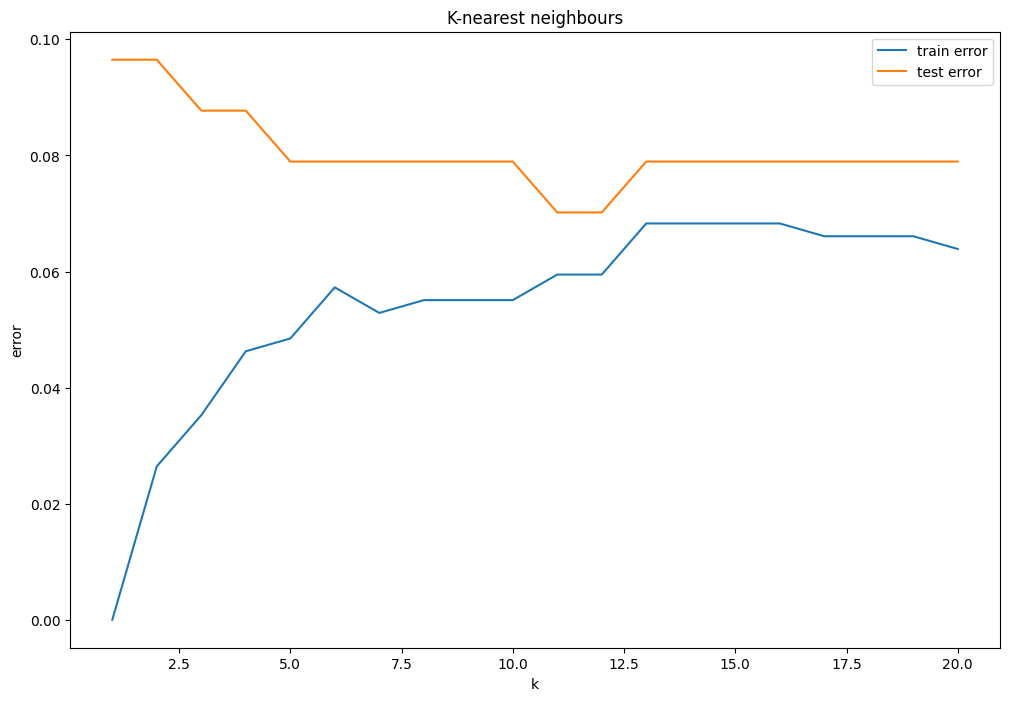

In [42]:
import numpy as np
import matplotlib.pyplot as plt
train_error = np.zeros(20)
test_error = np.zeros(20)

for k in range(1,21):
    class_test = knn.knn(X_train, y_train, X_train, k)
    train_error[k-1] = np.mean(class_test != y_train)
    class_test = knn.knn(X_train, y_train, X_test, k)
    test_error[k-1] = np.mean(class_test != y_test)

plt.figure(figsize=(12,8),dpi=100)
plt.plot(range(1,21),train_error,label='train error')
plt.plot(range(1,21),test_error,label='test error')
plt.legend()
plt.title('K-nearest neighbours')
plt.xlabel('k')
plt.ylabel('error')
plt.show()

We verify that the results are the same as the sklearn implementation

In [43]:
k = 5
class_test = knn.knn(X_train, y_train, X_test, k)
class_test_sklearn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).predict(X_test)
print(np.all(class_test == class_test_sklearn))

True


4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [44]:
print("time report for optimized knn with cython")
timeit_knn = %timeit -o knn.knn(X_train, y_train, X_test, 5)
knn_time = timeit_knn.average

print("time report for naive knn")
timeit_naive = %timeit -o naive_knn(X_train, y_train, X_test, 5)
naive_time = timeit_naive.average

time report for optimized knn with cython
6.23 ms ± 203 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
time report for naive knn
574 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We've successfully optimized the code by using cython.</br>
we get a speedup of 92 times

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [46]:
def gradient2D(X):
    """
    Compute the gradient of a 2D array

    Parameters
    ----------
    X : 2D array
        The input array

    Returns
    -------
    Yh : 2D array
        The horizontal gradient
    Yv : 2D array
        The vertical gradient
    """
    assert X.ndim == 2, 'X must be a 2D array'

    Yh = np.zeros_like(X)
    Yv = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1] - 1):
            Yh[i, j] = X[i, j + 1] - X[i, j]
        Yh[i, -1] = 0

    for j in range(X.shape[1]):
        for i in range(X.shape[0] - 1):
            Yv[i, j] = X[i + 1, j] - X[i, j]
        Yv[-1, j] = 0

    return Yh, Yv
def tv(X):
    """
    Compute the total variation of a 2D array.

    Parameters
    ----------
    X : 2D array
        Input array.

    Returns
    -------
    tv : float
        Total variation of the 2D array.
    """
    grad_y, grad_x = gradient2D(X)
    total_variation = 0.0
    for i in range(grad_y.shape[0]):
        for j in range(grad_y.shape[1]):
            total_variation += np.sqrt(grad_y[i, j]**2 + grad_x[i, j]**2)
    return total_variation


In [48]:
# improve the function using numba
from numba import jit

@jit
def gradient2D_numba(X):
    """
    Compute the gradient of a 2D array

    Parameters
    ----------
    X : 2D array
        The input array

    Returns
    -------
    Yh : 2D array
        The horizontal gradient
    Yv : 2D array
        The vertical gradient
    """
    assert X.ndim == 2, 'X must be a 2D array'

    Yh = np.zeros_like(X)
    Yv = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1] - 1):
            Yh[i, j] = X[i, j + 1] - X[i, j]
        Yh[i, -1] = 0

    for j in range(X.shape[1]):
        for i in range(X.shape[0] - 1):
            Yv[i, j] = X[i + 1, j] - X[i, j]
        Yv[-1, j] = 0

    return Yh, Yv

@jit
def tv_numba(X):
    """
    Compute the total variation of a 2D array.

    Parameters
    ----------
    X : 2D array
        Input array.

    Returns
    -------
    tv : float
        Total variation of the 2D array.
    """
    grad_y, grad_x = gradient2D_numba(X)
    total_variation = 0.0
    for i in range(grad_y.shape[0]):
        for j in range(grad_y.shape[1]):
            total_variation += np.sqrt(grad_y[i, j]**2 + grad_x[i, j]**2)
    return total_variation


2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [47]:
X = np.random.rand(1000,1000)
timeit_tv = %timeit -o tv(X)
np_time = timeit_tv.average

1.78 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
X = np.random.rand(1000,1000)
timeit_tv_namba = %timeit -o tv_numba(X)
numba_time = timeit_tv_namba.average

16 ms ± 763 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
Rappor = np_time / numba_time

In [53]:
print(f"numba is {Rappor} times faster than numpy")

numba is 110.89280243637164 times faster than numpy


We get better performance with numba indeed the function for total variation is 110 times faster with numba than with numpy

**Conclusion :** We can say that code acceleration is very important in machine learning. </br> We have seen that the use of cython and numba can significantly reduce the execution time of our code.</br> We have also seen that the use of sklearn is very efficient and that it is not necessary to use cython or numba to have a good execution time.